# NAIROBI AIR QUALITY MONITORING - PREDICTING PM2.5 CONCENTRATION
---


## Background of the Study

The world has been experiencing the biggest wave of urban growth in history[1]. Currently, over 50 per cent of the global population lives in urban areas- this is 3.9 billion, and by 2030, this number will rise to about 5 billion[1]. From an estimated 237 million in 1995 to an estimated 472 million in 2015, Africa experienced an average
urban growth of 3.44% per year[2]. Rapid industrialization and urbanization is associated with extremely severe air pollution that causes increasing negative effects on human health, visibility,and climate change[3].

According to World Health Organization, air pollution is associated with 7 million premature deaths annually [4]. In Kenya, approximately 19,112 die from air pollution, with
6,672 being children yearly[5]. Among these air pollutants, we have PM2.5 which can traversethe nasal passages thus bringing about a great threat to the human body [4].The study conducted by [6] in 2018 proposed that PM2.5 concentrations above minimum exposure levels caused 22% of infant deaths in the 30 countries that he was investigating [6].

With the growing of evidence linking air pollution to adverse health outcomes, an urgency arises on finding sustainable and innovative solutions. Predictive modeling stands as a promising avenue for facilitating timely public health interventions. By leveraging predictive modeling techniques, we can anticipate air pollution trends, identify high-risk areas, and implement targeted interventions to mitigate its impact on human health and the environment. Predicting air quality is a complex task due to the dynamic nature, volatility, and high variability in time and space of pollutants and particulates [7]. Based on the reviewed literature on Machine Learning Applications in Air Pollution. To the best of our knowledge,  no work was done involving the analysis and prediction of air pollution in Nairobi. Therefore this study intends to predict PM 2.5 concentration using linear machine learning models.

## Research objectives

1. To fit linear models.

2. To evaluate the models

3. To optimize the best model.

## Research Questions

1. How accurately can linear models predict PM2.5 concentrations in Nairobi?

2. How does the performance of different linear models compare in predicting PM2.5 concentrations?

3.  Can optimizing the parameters of linear models significantly improve their predictive accuracy?

4. What has been the progression/ trend of PM 2.5 concentration over the years?


## Data Description

This project intends to use data from Sensors Africa. Sensors AFRICA is a pan-African citizen science initiative that uses sensors to monitor air, water and sound pollution to give citizens actionable information about their cities. Sensors Africa uses low-cost air quality sensors to collect data on air pollution. The sensors are distributed in different areas within Nairobi.The sensors data is open source and can be found at: https://open.africa/dataset/sensorsafrica-airquality-archive-nairobi. The data has been collected from June 2017 to March 2024. The data is recorded at an interval of seconds from the different sensors on a daily basis. The specific variables found in the dataset are defined in the table below:

| Column Name| Description| Units | Sample Values |
|---- |----|----|----|
| Sensor_id  | Unique identifier used to differentiate the sensors within a network |-|49 |
| Sensor_type |The dataset has two types of sensors used: pms5003 (is a specific model of particulate matter (PM) sensor commonly used for air quality monitoring) and DHT22 ( is a type of sensor commonly used to measure temperature and humidity in the air) |- |pms5003, DHT22 |
| location  |  Location where the sensor is deployed, represented as numeric codes | -| 3573, 3612|
| lat  |Latitude coordinate of the sensor's location  | - | -1.296 |
| lon |Longitude coordinate of the sensor's location|-|36.776 |
|Timestamp|The date and time when the measurement was recorded by a particular sensor.|-|2024-01-01T00:12:22.156424+00:00|
|Value_type|Indicates the type of value being measured by the sensor. Where P0 in the data represents PM1, P2 represents PM2.5, and P1 represents PM10|- | P2, humidity,temperature |
|Value|The actual measurement value recorded by the sensor corresponding to the "value_type"| µg/m³, Temperature (C), Humidity (%) |P2 = 22.4µg/m³ |

---

In [2]:
#loading required libraries
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
from dateutil.parser import parse
# Define a custom date parser to handle inconsistent datetime formats
def custom_date_parser(date_str):
    return parse(date_str)

## Data Aggregation

- This step involves collecting and organizing raw data from various sources into a format that is easier to analyze. It may include summarizing, averaging, or otherwise consolidating data points to create a more manageable dataset. 

In [3]:
#Defining a function to perform the aggregation

def aggregate_sensor_data(data_dir, output_file):
    # Define the columns to keep
    columns_to_keep = ['timestamp', 'P2', 'P1', 'humidity']

    # Create an empty DataFrame to store the aggregated data
    aggregated_data = pd.DataFrame()

    # Use glob to get all file paths in the directory
    file_paths = glob.glob(f'{data_dir}/*.csv')

    for file_path in file_paths:
        # Read the data with appropriate dtype settings
        df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'], low_memory=False)

        # Drop the specified columns, ignoring errors if they do not exist
        columns_to_drop = ['location', 'sensor_id', 'sensor_type', 'lat', 'lon']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

        # Select only the columns needed for pivoting
        df = df[['timestamp', 'value_type', 'value']]

        # Temporarily rename 'timestamp' to avoid conflicts during pivoting
        df.rename(columns={'timestamp': 'timestamp_temp'}, inplace=True)

        # Pivot the DataFrame to have value_type as columns
        df_pivot = df.pivot_table(index='timestamp_temp', columns='value_type', values='value', aggfunc='first').reset_index()

        # Rename 'timestamp_temp' back to 'timestamp'
        df_pivot.rename(columns={'timestamp_temp': 'timestamp'}, inplace=True)

        # Ensure no duplicate columns
        df_pivot = df_pivot.loc[:, ~df_pivot.columns.duplicated()]

        # Select only the columns to keep (some columns might not exist in some datasets, hence the intersection)
        df_pivot = df_pivot[['timestamp'] + list(set(columns_to_keep) & set(df_pivot.columns))]

        # Append to the aggregated DataFrame
        aggregated_data = pd.concat([aggregated_data, df_pivot], ignore_index=True)

    # Drop any duplicate 'timestamp' columns if they exist
    aggregated_data = aggregated_data.loc[:,~aggregated_data.columns.duplicated()]

    # Save the aggregated data to a new CSV file
    aggregated_data.to_csv(output_file, index=False)

In [4]:
# Applying the function
data_dir = 'C:/Users/USER/Documents/Msc_DSA/Module 2/Research Methodology/Sensor Africal Data for Nairobi/Analysis/Data'
output_file = 'aggregated_data.csv'
aggregate_sensor_data(data_dir, output_file)


**Loading the aggregated data**

In [5]:
# Load the data
data = pd.read_csv('aggregated_data.csv')
data.head()

,timestamp,P1,humidity,P2
0,2018-04-01 00:02:07.071983+00:00,NaN,65.8,NaN
1,2018-04-01 00:02:07.111462+00:00,7.8,NaN,4.4
2,2018-04-01 00:03:56.860816+00:00,NaN,76.3,NaN
3,2018-04-01 00:04:36.364175+00:00,6.83,NaN,4.43
4,2018-04-01 00:07:18.801040+00:00,7.87,NaN,4.5


In [6]:
data.shape

(27722456, 4)

In [8]:
data.dtypes

timestamp    object
P1           object
humidity     object
P2           object
dtype: object

**Dealing with Timestamp data**

In [24]:
# checking the format of the timestamps in my dataset
import re

def check_format(timestamp):
    if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3,6}[+-]\d{2}:\d{2}', timestamp): #'%Y-%m-%d %H:%M:%S.%f%z'
        return 'Format 1'
    elif re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}[+-]\d{2}:\d{2}', timestamp): # %Y-%m-%dT%H:%M:%S.%f%z
        return 'Format 2'
    elif re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}[+-]\d{2}:\d{2}', timestamp): #  %Y-%m-%dT%H:%M:%S%z
        return 'Format 3'
    else:
        return 'Unknown Format'
        
# Apply function to your timestamp column
data['timestamp_format'] = data['timestamp'].apply(check_format)

# Print the results
data[['timestamp', 'timestamp_format']]

,timestamp,timestamp_format
0,2018-04-01 00:02:07.071983+00:00,Format 1
1,2018-04-01 00:02:07.111462+00:00,Format 1
2,2018-04-01 00:03:56.860816+00:00,Format 1
3,2018-04-01 00:04:36.364175+00:00,Format 1
4,2018-04-01 00:07:18.801040+00:00,Format 1
...,...,...
27722451,2023-09-27 13:12:23.073517+00:00,Format 1
27722452,2023-09-27 13:12:24.162530+00:00,Format 1
27722453,2023-09-27 13:12:34.119551+00:00,Format 1
27722454,2023-09-27 13:12:46.703602+00:00,Format 1


In [25]:
# Filter rows with unknown format
unknown_format_df = data[data['timestamp_format'] == 'Unknown Format']
unknown_format_df

,timestamp,P1,humidity,P2,timestamp_format


-> All the formats in the datasets were identified and none of them was identified as unknown

In [29]:
from datetime import datetime

#Defining timestamp to datetime
def parse_timestamp(timestamp, fmt):
    if fmt == 'Format 1':
        return datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f%z')
    elif fmt == 'Format 2':
        return datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f%z')
    elif fmt == 'Format 3':
        return datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z')
    else:
        return None


In [30]:
# Applying the function to the data
data['parsed_timestamp'] = data.apply(lambda row: parse_timestamp(row['timestamp'], row['timestamp_format']), axis=1)

# Sort the DataFrame by the parsed timestamps
data = data.sort_values(by='parsed_timestamp')

# Reset index after sorting
data = data.reset_index(drop=True)
data


,timestamp,P1,humidity,P2,timestamp_format,parsed_timestamp
0,2018-01-01 00:02:00.522075+00:00,27.2,NaN,12.4,Format 1,2018-01-01 00:02:00.522075+00:00
1,2018-01-01 00:02:09.561058+00:00,27.2,NaN,12.4,Format 1,2018-01-01 00:02:09.561058+00:00
2,2018-01-01 00:02:18.891954+00:00,NaN,55.7,NaN,Format 1,2018-01-01 00:02:18.891954+00:00
3,2018-01-01 00:02:28.422689+00:00,NaN,55.7,NaN,Format 1,2018-01-01 00:02:28.422689+00:00
4,2018-01-01 00:05:13.601185+00:00,18.43,NaN,12.13,Format 1,2018-01-01 00:05:13.601185+00:00
...,...,...,...,...,...,...
27722451,2024-03-19 04:29:38.801140+00:00,NaN,99.9,NaN,Format 1,2024-03-19 04:29:38.801140+00:00
27722452,2024-03-19 04:29:54.950380+00:00,45.0,NaN,43.0,Format 1,2024-03-19 04:29:54.950380+00:00
27722453,2024-03-19 04:30:09.830855+00:00,47.2,NaN,38.2,Format 1,2024-03-19 04:30:09.830855+00:00
27722454,2024-03-19 04:30:10.744598+00:00,NaN,99.9,NaN,Format 1,2024-03-19 04:30:10.744598+00:00


In [31]:
# Drop unnecessary columns
data_cleaned = data.drop(columns=['timestamp_format','timestamp'])

# Set parsed_timestamp as the index
data_cleaned = data_cleaned.set_index('parsed_timestamp')

# Rename the index to 'timestamp'
data_cleaned.index.name = 'timestamp'
data_cleaned

,P1,humidity,P2
timestamp,,,
2018-01-01 00:02:00.522075+00:00,27.2,NaN,12.4
2018-01-01 00:02:09.561058+00:00,27.2,NaN,12.4
2018-01-01 00:02:18.891954+00:00,NaN,55.7,NaN
2018-01-01 00:02:28.422689+00:00,NaN,55.7,NaN
2018-01-01 00:05:13.601185+00:00,18.43,NaN,12.13
...,...,...,...
2024-03-19 04:29:38.801140+00:00,NaN,99.9,NaN
2024-03-19 04:29:54.950380+00:00,45.0,NaN,43.0
2024-03-19 04:30:09.830855+00:00,47.2,NaN,38.2


**Converting the data types**

In [32]:
data_cleaned.dtypes

P1          object
humidity    object
P2          object
dtype: object

In [34]:
# Convert columns to numeric types, using `pd.to_numeric` with `errors='coerce'` to handle non-numeric values
data_cleaned['P1'] = pd.to_numeric(data_cleaned['P1'], errors='coerce')
data_cleaned['humidity'] = pd.to_numeric(data_cleaned['humidity'], errors='coerce')
data_cleaned['P2'] = pd.to_numeric(data_cleaned['P2'], errors='coerce')

# Print the data types after conversion
data_cleaned.dtypes

# Print the cleaned DataFrame
data_cleaned

,P1,humidity,P2
timestamp,,,
2018-01-01 00:02:00.522075+00:00,27.20,NaN,12.40
2018-01-01 00:02:09.561058+00:00,27.20,NaN,12.40
2018-01-01 00:02:18.891954+00:00,NaN,55.7,NaN
2018-01-01 00:02:28.422689+00:00,NaN,55.7,NaN
2018-01-01 00:05:13.601185+00:00,18.43,NaN,12.13
...,...,...,...
2024-03-19 04:29:38.801140+00:00,NaN,99.9,NaN
2024-03-19 04:29:54.950380+00:00,45.00,NaN,43.00
2024-03-19 04:30:09.830855+00:00,47.20,NaN,38.20


## Dealing with missing values

In [35]:
#checking for null values
data_cleaned.isna().sum()

P1          11973951
humidity    15754524
P2          11973950
dtype: int64

Possible reason for the missing values:

* By using errors='coerce', numbers such as: '12n80', '1^80', '44.w0', 'y4.30', '92>50' were converted to Null values -> Data entry error 
* Since the data was being collected by sensors, there is a possibility that in a particular second data was not collected by the sensor -> Missing data

 ***Analysis before imputing the data***

In [36]:
data_cleaned.describe()

,P1,humidity,P2
count,1.574850e+07,1.196793e+07,1.574851e+07
mean,2.257947e+01,1.045576e+02,1.831569e+01
std,3.560880e+01,1.520580e+03,2.939018e+01
min,-1.000000e+00,-2.000000e+02,-1.000000e+00
25%,9.850000e+00,5.280000e+01,7.000000e+00
50%,1.670000e+01,6.570000e+01,1.375000e+01
75%,2.600000e+01,8.960000e+01,2.200000e+01
max,2.254330e+03,6.553500e+04,1.124400e+03


array([[<Axes: title={'center': 'P1'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'P2'}>, <Axes: >]], dtype=object)

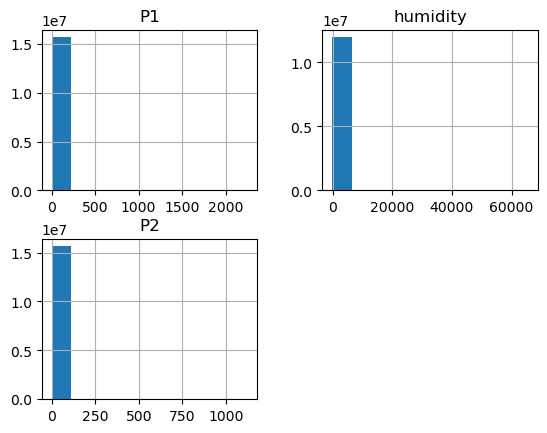

In [37]:
data_cleaned.hist()

<Axes: >

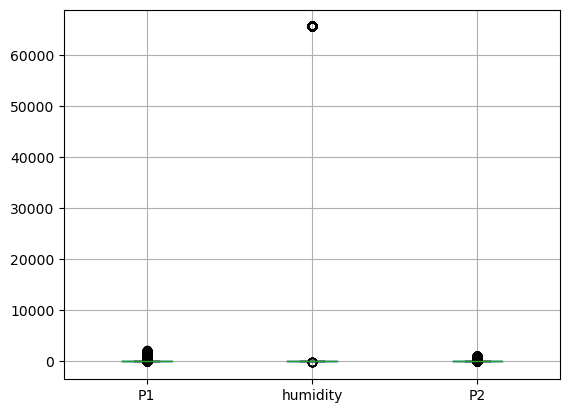

In [38]:
data_cleaned.boxplot()

**Performing imputation using interpolation**

-> Interpolation is mostly used while working with time-series data because, in time-series data, we like to fill missing values with the previous one or two values. 

https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/

In [44]:
# Apply linear interpolation
df_interpolated = data_cleaned.interpolate(method='linear',limit_direction ='both')
df_interpolated

,P1,humidity,P2
timestamp,,,
2018-01-01 00:02:00.522075+00:00,27.200000,55.700000,12.40
2018-01-01 00:02:09.561058+00:00,27.200000,55.700000,12.40
2018-01-01 00:02:18.891954+00:00,24.276667,55.700000,12.31
2018-01-01 00:02:28.422689+00:00,21.353333,55.700000,12.22
2018-01-01 00:05:13.601185+00:00,18.430000,55.766667,12.13
...,...,...,...
2024-03-19 04:29:38.801140+00:00,48.500000,99.900000,42.00
2024-03-19 04:29:54.950380+00:00,45.000000,99.900000,43.00
2024-03-19 04:30:09.830855+00:00,47.200000,99.900000,38.20


In [45]:
df_interpolated.isna().sum()

P1          0
humidity    0
P2          0
dtype: int64

***Analysis after imputation***

In [54]:
df_interpolated.describe()

,P1,humidity,P2
count,2.772246e+07,2.772246e+07,2.772246e+07
mean,2.256556e+01,1.025309e+02,1.821067e+01
std,3.074710e+01,1.271658e+03,2.519300e+01
min,-1.000000e+00,-2.000000e+02,-1.000000e+00
25%,1.056500e+01,5.460000e+01,7.700000e+00
50%,1.702500e+01,6.810000e+01,1.400000e+01
75%,2.640000e+01,8.620000e+01,2.250000e+01
max,2.254330e+03,6.553500e+04,1.124400e+03


array([[<Axes: title={'center': 'P1'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'P2'}>, <Axes: >]], dtype=object)

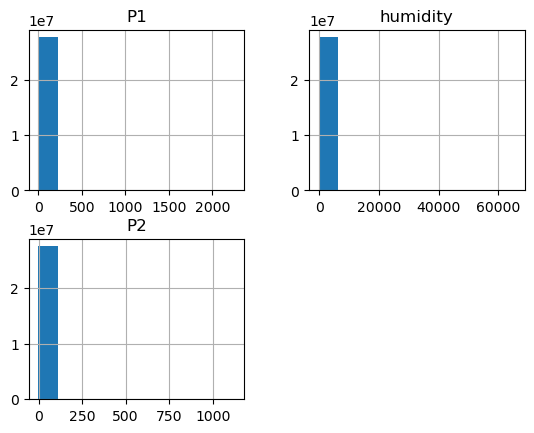

In [52]:
df_interpolated.hist()

<Axes: >

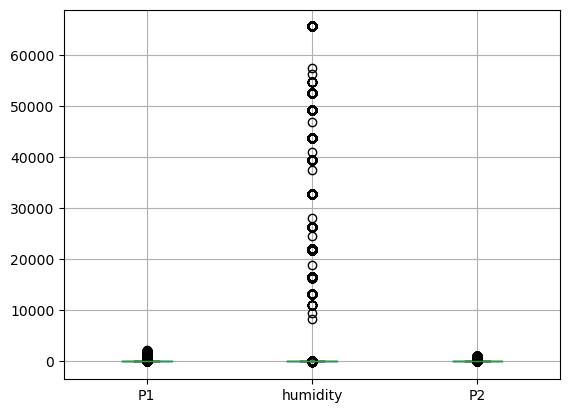

In [55]:
df_interpolated.boxplot()

## Resampling the data to daily

In [56]:
# Resample to daily frequency, e.g., using the mean of the values per day
df1 = df_interpolated.resample('D').mean()
df1

,P1,humidity,P2
timestamp,,,
2018-01-01 00:00:00+00:00,22.340921,50.413740,10.614917
2018-01-02 00:00:00+00:00,50.618430,56.260093,22.822799
2018-01-03 00:00:00+00:00,42.808169,61.215489,18.967205
2018-01-04 00:00:00+00:00,55.252669,66.257806,29.112031
2018-01-05 00:00:00+00:00,45.205250,55.823218,22.735453
...,...,...,...
2024-03-15 00:00:00+00:00,32.890541,97.299513,28.021744
2024-03-16 00:00:00+00:00,43.526250,85.594703,36.743619
2024-03-17 00:00:00+00:00,27.044263,65.544379,23.572891


**Checking for missing values**

In [82]:
df1.isna().sum()

timestamp     0
P1           34
humidity     34
P2           34
dtype: int64

In [83]:
df1 = df1.interpolate(method='linear')

In [84]:
df1.isna().sum()

timestamp    0
P1           0
humidity     0
P2           0
dtype: int64

## Loading more data

**Precipitation Data**

In [85]:
df2=pd.read_csv('C:/Users/USER/Documents/Msc_DSA/Module 2/Research Methodology/Sensor Africal Data for Nairobi/Analysis/Satellite Data/Precipitation.csv')
# Convert 'timestamp' to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format='%b %d, %Y')

df2.dtypes

timestamp        datetime64[ns]
precipitation           float64
dtype: object

In [86]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2024-03-20')

# Drop rows where the timestamp is on or after the cutoff date
df2 = df2[df2['timestamp'] < cutoff_date]
df2

,timestamp,precipitation
0,2018-01-01,0.489
1,2018-01-02,3.496
2,2018-01-03,5.400
3,2018-01-04,2.720
4,2018-01-05,0.000
...,...,...
2265,2024-03-15,0.000
2266,2024-03-16,0.000
2267,2024-03-17,0.000
2268,2024-03-18,0.000


In [87]:
# Checking for null values
df2.isna().sum()

timestamp        0
precipitation    0
dtype: int64

**Temperature Data**

In [88]:
df3= pd.read_csv('C:/Users/USER/Documents/Msc_DSA/Module 2/Research Methodology/Sensor Africal Data for Nairobi/Analysis/Satellite Data/Temperature.csv')
# Convert 'timestamp' to datetime
df3['timestamp'] = pd.to_datetime(df3['timestamp'], format='%Y-%m-%d')

df3.dtypes

timestamp       datetime64[ns]
temperature            float64
dtype: object

In [89]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2024-03-20')

# Drop rows where the timestamp is on or after the cutoff date
df3 = df3[df3['timestamp'] < cutoff_date]
df3

,timestamp,temperature
0,2018-01-01,21.4613
1,2018-01-02,21.1622
2,2018-01-03,19.4010
3,2018-01-04,18.0373
4,2018-01-05,18.4811
...,...,...
2265,2024-03-15,20.3418
2266,2024-03-16,20.8429
2267,2024-03-17,22.3856
2268,2024-03-18,21.8343


In [90]:
# Checking for null values
df3.isna().sum()

timestamp       0
temperature     0
dtype: int64

**Wind speed Data**

In [91]:
df4 = pd.read_csv('C:/Users/USER/Documents/Msc_DSA/Module 2/Research Methodology/Sensor Africal Data for Nairobi/Analysis/Satellite Data/Wind speed.csv')
# Convert 'timestamp' to datetime
df4['timestamp'] = pd.to_datetime(df4['timestamp'], format='%Y-%m-%d')

df4.dtypes

timestamp     datetime64[ns]
wind speed           float64
dtype: object

In [92]:
# Define the cutoff date
cutoff_date = pd.Timestamp('2024-03-20')

# Drop rows where the timestamp is on or after the cutoff date
df4 = df4[df4['timestamp'] < cutoff_date]
df4

,timestamp,wind speed
0,2018-01-01,0.7640
1,2018-01-02,0.3317
2,2018-01-03,0.3039
3,2018-01-04,0.1981
4,2018-01-05,1.0235
...,...,...
2265,2024-03-15,3.2414
2266,2024-03-16,2.3932
2267,2024-03-17,2.2987
2268,2024-03-18,2.7257


In [93]:
# Checking for null values
df4.isna().sum()

timestamp     0
wind speed    0
dtype: int64

## Merging all four datasets

In [94]:
#Removing timezone
df1 = df1.reset_index()
df1['timestamp'] = df1['timestamp'].dt.tz_localize(None)
df2['timestamp'] = df2['timestamp'].dt.tz_localize(None)
df3['timestamp'] = df3['timestamp'].dt.tz_localize(None)
df4['timestamp'] = df4['timestamp'].dt.tz_localize(None)

In [97]:
# Merge df1 with df2
merged_df = pd.merge(df1, df2, on='timestamp', how='inner')
merged_df = pd.merge(merged_df, df3, on='timestamp', how='inner')
merged_df = pd.merge(merged_df, df4, on='timestamp', how='inner')

# Set 'timestamp' as the index
merged_df = merged_df.drop(columns=['index'])
merged_df.set_index('timestamp', inplace=True)
merged_df

,P1,humidity,P2,precipitation,temperature,wind speed
timestamp,,,,,,
2018-01-01,22.340921,50.413740,10.614917,0.489,21.4613,0.7640
2018-01-02,50.618430,56.260093,22.822799,3.496,21.1622,0.3317
2018-01-03,42.808169,61.215489,18.967205,5.400,19.4010,0.3039
2018-01-04,55.252669,66.257806,29.112031,2.720,18.0373,0.1981
2018-01-05,45.205250,55.823218,22.735453,0.000,18.4811,1.0235
...,...,...,...,...,...,...
2024-03-15,32.890541,97.299513,28.021744,0.000,20.3418,3.2414
2024-03-16,43.526250,85.594703,36.743619,0.000,20.8429,2.3932
2024-03-17,27.044263,65.544379,23.572891,0.000,22.3856,2.2987


In [98]:
# Checking for null values
merged_df.isna().sum()

P1               0
humidity         0
P2               0
precipitation    0
temperature      0
wind speed       0
dtype: int64

In [99]:
merged_df.to_csv('data.csv')

---